In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# accelerate huggingface to GPU
if torch.cuda.is_available():
    from accelerate import Accelerator
    accelerator = Accelerator()
    device = accelerator.device

torch.manual_seed(42)
random.seed(42)

In [2]:
folder = 'results_sweep_zall_150122'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}')    
runs1=os.listdir(pointer)
runs=[] 
for run in runs1:
    if run[-1]=='2':
        runs.append(run) 
# total of 5 for each z
# runs.sort()
# try
model_runs = []
construct_dicts = []
for run in runs:
    if os.listdir(osp.join(pointer, run, 'trained_model'))==['model.pt']:
        model_runs.append(run)
        construct_dicts.append(pickle.load(open(osp.join(pointer,run[:-4],'construct_dict.pkl'), 'rb')))

In [3]:
# folder = 'results_sweep_highz_140122' 
# pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}')    
# runs1=os.listdir(pointer)
# runs=[] 
# z=2.0
# for run in runs1:
#     if run[-1]=='3' and f'{z}' in run:
#         runs.append(run) 
# # total of 5 for each z
# # runs.sort()
# # try
# model_runs = []
# construct_dicts = []
# for run in runs:
#     if os.listdir(osp.join(pointer, run, 'trained_model'))==['model.pt']:
#         model_runs.append(run)
#         construct_dicts.append(pickle.load(open(osp.join(pointer,run[:-4],'construct_dict.pkl'), 'rb')))

In [4]:
construct_dict = construct_dicts[0]

In [5]:
model_runs

['Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_frnlfw_2_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_kappnu_2_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_yahxau_2_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qbkwvj_2_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qozzif_1_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_kappnu_1_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qozzif_2_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_qbkwvj_1_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_yahxau_1_2',
 'Sage_vlarge_all_4t_zall_quantile_raw_trainandtest_frnlfw_1_2']

In [33]:
case='vlarge_all_4t_z3.0_quantile_raw'

datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl'), 'rb'))

In [34]:
from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[0]))

In [35]:
from sklearn.model_selection import train_test_split
# train_data, test_data=train_test_split(data, test_size=0.2)
split=0.8
test_data=data[int(len(data)*split):]
train_data=data[:int(len(data)*split)]
batch_size=construct_dict['run_params']['batch_size']

In [36]:
def setup_model(model_name, hyper_params):
    os.chdir('..')
    # Retrieve name and params for construction

    # Load model from model folder
    import dev.models as models
    model         = getattr(models, model_name) 
    model         = model(**hyper_params)
    os.chdir('analyse_model')
    return model

In [37]:
stds = []
for k in range(len(construct_dicts)):
    construct_dict = construct_dicts[k]
    model=setup_model(construct_dict['model'], construct_dict['hyper_params'])
    model.load_state_dict(torch.load(osp.join(pointer, model_runs[k], 'trained_model', 'model.pt')))
    train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1, num_workers=1)
    test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=0,num_workers=1)    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    _, _, test_loader = accelerator.prepare(model, optimizer, test_loader)
    model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)
    model.eval()
    loader=test_loader
    model.eval()
    outs = []
    ys = []
    with torch.no_grad(): ##this solves it!!!
        for dat in loader: 
            out, var = model(dat) 
            ys.append(dat.y.view(-1,1))
            outs.append(out)
    outss=torch.vstack(outs)
    yss=torch.vstack(ys)
    stds.append(torch.std(outss-yss).cpu().numpy())
    print(torch.std(outss-yss))

RelU conv activation
LeakyRelU decode activation
tensor(0.1048, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1075, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1009, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1112, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1099, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1067, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1074, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1066, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1215, device='cuda:0')
RelU conv activation
LeakyRelU decode activation
tensor(0.1073, device='cuda:0')


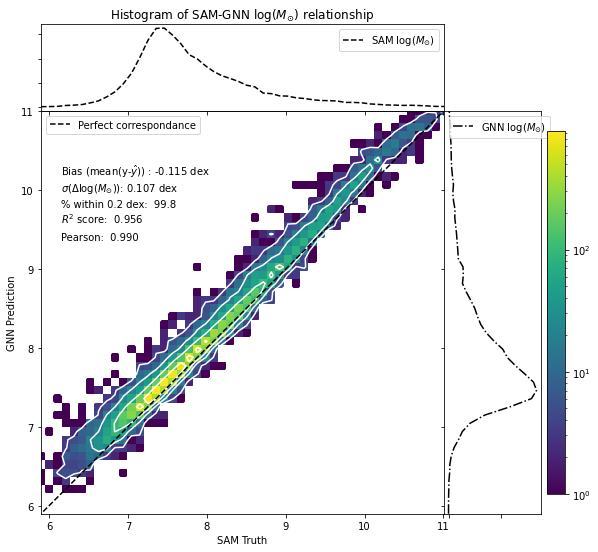

In [38]:
plot(yss.cpu().numpy().flatten()+9, outss.cpu().numpy().flatten()+9, 1.75)

In [39]:
# z = 0.5 
np.mean(stds), np.std(stds)


(0.10838483, 0.005107765)

In [ ]:
# z = 0.25,0,75 , 1.5, 3

(0.073137235, 0.0013167991) (-0.011)

(0.06762478, 0.00068282936) (0.011)

(0.074327946, 0.0015762349) (0.008)

(0.10838483, 0.005107765) (-0.11)

# np.mean(stds), np.std(stds)
# ([0.20579257, 0.1560455, 0.08998191], [0.040139306, 0.01847149, 0.025444217])

In [15]:
from matplotlib.ticker import NullFormatter
from scipy import stats

def plot(ys, pred, z):
    target=r"log($M_{\odot}$)"
    # target=r"$v_{disk}$"

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.7
    bottom, height = 0.1, 0.7
    bottom_h = left_h = left + width
    # rect_Cbar = [0, bottom, 0.1, height]
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.15]
    rect_histy = [left_h, bottom, 0.15+0.06, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))
    # axCbar = plt.axes(rect_Cbar)
    axHist = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    axHistx.yaxis.set_major_formatter(nullfmt)
    axHisty.xaxis.set_major_formatter(nullfmt)

    bins=50
    l=0.01
    xt=0.05
    yt=0.8
    n_contour=4
    # the scatter plot:
    vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
    X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
    axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
    axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
    axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
    axHist.legend()

    # now determine nice limits by hand:
    X, Y = X[0], Y.T[0]
    axHist.set_xlim((min(X), max(X)))
    axHist.set_ylim((min(Y), max(Y)))
    yhat=r'$\hat{y}$'
    pct=np.sum((ys-pred)<0.2)/len(ys-pred)

    r2=r2_score(ys,pred)
    rho = np.corrcoef(ys,pred)[0,1]
    axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys-pred):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys-pred):.3f} dex', transform=axHist.transAxes)
    axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
    axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



    # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
    # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
    ys_kde = stats.gaussian_kde(ys, 0.05)
    pred_kde = stats.gaussian_kde(pred, 0.05)
    axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
    axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN {target}')
    axHistx.legend()
    axHisty.legend(loc='upper left')

    axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

    axHistx.set_xlim(axHist.get_xlim())
    axHisty.set_ylim(axHist.get_ylim())

    plt.colorbar(hist, ax=axHisty, location='right')

    plt.show()